# Developing a robust CNN model to address the challenge of learning with label noise in  CIFAR10 dataset

- CIFAR10 Label : ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

- image size : 3x32x32




In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, random_split
import os
import time
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

In [2]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

## Load and normalize CIFAR10

- Transform them to Tensors of normalized range [-1, 1].

In [3]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)


# Training transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

100%|██████████| 170498071/170498071 [00:02<00:00, 65895291.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
# Validation and testing transformations
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [5]:
dataset_size = len(cifar_dataset)
validation_split = 0.2
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(cifar_dataset, [train_size, val_size])

In [6]:
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

# dataloader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=False,
                                          download=True,
                                          transform = transform_test)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [8]:
class_names = cifar_dataset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Noise Labeling
- 4 different noise levels (10%,
30%, 60%, 90%)

In [9]:
def apply_label_noise(labels, epsilon, noise_type):
    num_labels = len(labels)
    num_flips = int(epsilon * num_labels)

    if noise_type == 'symmetric':
        # symmetric label noise
        flip_indices = np.random.choice(num_labels, num_flips, replace=False)
        labels[flip_indices] = np.random.randint(0, 10, num_flips)

    elif noise_type == 'asymmetric':
        # asymmetric label noise
        flip_rules = {
            9: 1,   # Truck to Automobile
            2: 0,   # Bird to Airplane
            4: 7,   # Deer to Horse
            3: 5,   # Cat to Dog
            5: 3,   # Dog to Cat
        }

        for i in range(num_labels):
            if np.random.random() < epsilon:
                labels[i] = flip_rules.get(labels[i], labels[i])

    return labels

# Baseline Model

In [11]:
class BaselineModel(nn.Module):
  def __init__(self):
    super(BaselineModel,self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 8, kernel_size=3, padding = 1),  # (input channel, output channels, kernel size, padding)  32*32*8
      nn.ReLU(inplace=True), # activation function modifies the input tensor directly
      nn.Conv2d(8, 16, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2,stride=2), # 16*16*16

      nn.Conv2d(16, 32, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.MaxPool2d(kernel_size=2,stride=2) # 8*8*128
    )

    # fully connected layers
    self.fc_layers = nn.Sequential(
      nn.Linear(128*8*8, 512),
      nn.ReLU(inplace=True),
      nn.Linear(512,10)
    )

    # apply Xavier initialization to the weights of linear layers
    for m in self.fc_layers:
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x,1)
    x = self.fc_layers(x)
    return x

In [17]:
# hyperparameter
num_epochs = 7
noise_levels = [0.1, 0.3, 0.6, 0.9]

### Run model without noise

In [43]:
# training

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
training_times = []
validation_times = []

num_epochs = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)  # Learning rate scheduler (cosine annealing)

model.train()

# initialize variables to measure training time
start_time_train = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    # measure and print epoch training time
    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Training Time: {epoch_time:.2f}')

    # store training metrics
    train_losses.append(loss.item())
    train_accuracies.append(100 * total_correct / total_samples)

    # update learning rate
    scheduler.step()

# store total training time
total_train_time = time.time() - start_time_train
training_times.append(total_train_time)
print(f'Total Training Time: {total_train_time:.2f} seconds')

# validation
model.eval()

# initialize variables to measure validation time
start_time_val = time.time()

val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

        # calculate validation accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


# measure and print validation time
total_val_time = time.time() - start_time_val
validation_times.append(total_val_time)
print(f'Total Validation Time: {total_val_time:.2f} seconds')

# store validation metrics
val_accuracy = correct / total
average_val_loss = val_loss / len(val_loader)
val_losses.append(average_val_loss)
val_accuracies.append(val_accuracy)

print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {val_accuracy}')

# print the total time for the entire training process
total_training_process_time = sum(training_times) + sum(validation_times)
print(f'Total Training Process Time: {total_training_process_time:.2f} seconds')


Epoch 1/7, Loss: 1.7317789793014526, Training Time: 14.07
Epoch 2/7, Loss: 1.2644438743591309, Training Time: 20.92
Epoch 3/7, Loss: 1.327405571937561, Training Time: 13.88
Epoch 4/7, Loss: 0.9764063954353333, Training Time: 15.35
Epoch 5/7, Loss: 0.8991012573242188, Training Time: 14.18
Epoch 6/7, Loss: 0.8522163033485413, Training Time: 13.82
Epoch 7/7, Loss: 0.6911526322364807, Training Time: 15.69
Total Training Time: 107.93 seconds
Total Validation Time: 3.02 seconds
Validation Loss: 1.011916697025299, Validation Accuracy: 0.6626
Total Training Process Time: 110.95 seconds


In [44]:
# testing
model.eval()

test_losses = []
test_accuracies = []

start_time_test = time.time()

with torch.no_grad():
    total_test_correct = 0
    total_test_samples = 0
    test_loss = 0.0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        # calculate test accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_test_samples += labels.size(0)
        total_test_correct += (predicted == labels).sum().item()

# store test metrics
test_accuracy = total_test_correct / total_test_samples
average_test_loss = test_loss / len(test_loader)
test_losses.append(average_test_loss)
test_accuracies.append(test_accuracy)

# print test metrics
print(f'Test Loss: {average_test_loss}, Test Accuracy: {test_accuracy}')

# print the total time for the testing process
total_test_time = time.time() - start_time_test
print(f'Total Test Time: {total_test_time:.2f} seconds')

Test Loss: 1.0248905956745147, Test Accuracy: 0.6586
Total Test Time: 2.62 seconds


## Train & Validation and Testing - symmetric noise label

In [12]:
# create a dictionary with keys in the format 'noise_level_{100 * value}'
model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize lists to store metrics
train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
training_times = []
validation_times = []

# training
for epsilon in noise_levels:

    model = BaselineModel()
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)  # Learning rate scheduler (cosine annealing)

    model.train()

    print(f"Symmetric Training with noise level: {epsilon}")

    # initialize variables to measure training time
    start_time_train = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:

            # add symmetric noise to labels
            labels = apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric')
            labels = torch.from_numpy(labels)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Training Time: {epoch_time:.2f}')

        # store training metrics
        train_losses[epsilon].append(loss.item())
        train_accuracies[epsilon].append(100 * total_correct / total_samples)

        # Update learning rate
        scheduler.step()

    # store total training time
    total_train_time = time.time() - start_time_train
    training_times.append(total_train_time)
    print(f'Total Training Time for noise level {epsilon}: {total_train_time:.2f} seconds')

    # validation
    model.eval()

    # initialize variables to measure validation time
    start_time_val = time.time()

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure and print validation time
    total_val_time = time.time() - start_time_val
    validation_times.append(total_val_time)
    print(f'Total Validation Time for noise level {epsilon}: {total_val_time:.2f} seconds')

    # store validation metrics
    val_accuracy = correct / total
    average_val_loss = val_loss / len(val_loader)
    val_losses[epsilon].append(average_val_loss)
    val_accuracies[epsilon].append(val_accuracy)

    print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {val_accuracy}')

    # save model to dictionary
    model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = {
        'state_dict': model.state_dict(),
        'validation_loss': average_val_loss,
        'validation_accuracy': val_accuracy
    }

# print the total time for the entire training process
total_training_process_time = sum(training_times) + sum(validation_times)
print(f'Total Training Process Time: {total_training_process_time:.2f} seconds')

Symmetric Training with noise level: 0.1
Epoch 1/7, Loss: 2.027905225753784, Training Time: 17.15
Epoch 2/7, Loss: 1.5788865089416504, Training Time: 16.48
Epoch 3/7, Loss: 1.3946117162704468, Training Time: 15.70
Epoch 4/7, Loss: 1.352346658706665, Training Time: 17.39
Epoch 5/7, Loss: 1.1565381288528442, Training Time: 17.82
Epoch 6/7, Loss: 1.3677055835723877, Training Time: 15.71
Epoch 7/7, Loss: 1.0385191440582275, Training Time: 14.63
Total Training Time for noise level 0.1: 114.89 seconds
Total Validation Time for noise level 0.1: 5.25 seconds
Validation Loss: 1.0735537469387055, Validation Accuracy: 0.6368
Symmetric Training with noise level: 0.3
Epoch 1/7, Loss: 2.1067051887512207, Training Time: 18.26
Epoch 2/7, Loss: 1.7719268798828125, Training Time: 17.86
Epoch 3/7, Loss: 1.6857192516326904, Training Time: 14.86
Epoch 4/7, Loss: 1.8855633735656738, Training Time: 14.09
Epoch 5/7, Loss: 1.65256929397583, Training Time: 13.77
Epoch 6/7, Loss: 1.6677794456481934, Training Tim

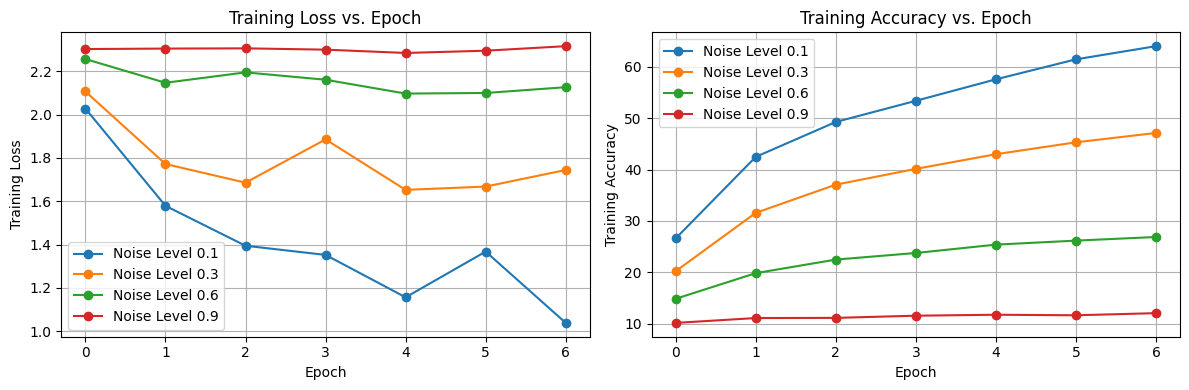

In [13]:
# plot training loss & accuracy for each noise level
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for epsilon, losses in train_losses.items():
    plt.plot(losses, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for epsilon, accuracies in train_accuracies.items():
    plt.plot(accuracies, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
test_accuracies = []
testing_times = []

# testing
for key, model_state_info in model_dict.items():
    model = BaselineModel()
    model_state = model.state_dict()
    model_state.update({k: v for k, v in model_state_info['state_dict'].items() if k in model_state})

    # load the updated state_dict
    model.load_state_dict(model_state)

    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    # initialize variables to measure testing time
    start_time_test = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure testing time
    total_test_time = time.time() - start_time_test
    testing_times.append(total_test_time)
    print(f'Total Testing Time for {key}: {total_test_time:.2f} seconds')

    # calculate test accuracy
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for {key}: {accuracy}')

# print the total time for the entire testing process
total_testing_process_time = sum(testing_times)
print(f'Total Testing Process Time: {total_testing_process_time:.2f} seconds')

Total Testing Time for noise_level_10_sy: 3.37 seconds
Test Accuracy for noise_level_10_sy: 0.6283
Total Testing Time for noise_level_30_sy: 2.55 seconds
Test Accuracy for noise_level_30_sy: 0.6003
Total Testing Time for noise_level_60_sy: 2.57 seconds
Test Accuracy for noise_level_60_sy: 0.5121
Total Testing Time for noise_level_90_sy: 2.49 seconds
Test Accuracy for noise_level_90_sy: 0.3154
Total Testing Process Time: 10.98 seconds


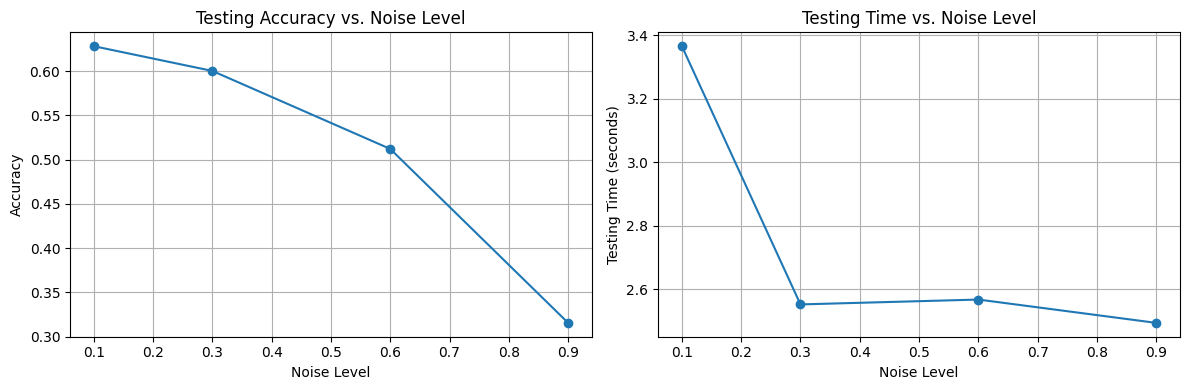

In [15]:
# plot testing accuracy and time
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, test_accuracies, marker='o')
plt.title('Testing Accuracy vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels,  testing_times, marker='o')
plt.title('Testing Time vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Testing Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Train & Validation and Testing - asymmetric noise label

In [18]:
# create a dictionary with keys in the format 'noise_level_{100 * value}'
model_dict = {f'noise_level_{int(100 * level)}_asy': None for level in noise_levels}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize lists to store metrics
train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
training_times = []
validation_times = []

# training
for epsilon in noise_levels:

    model = BaselineModel()
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)  # Learning rate scheduler (cosine annealing)

    model.train()

    print(f"Asymmetric Training with noise level: {epsilon}")

    # initialize variables to measure training time
    start_time_train = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:

            # add symmetric noise to labels
            labels = apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='asymmetric')
            labels = torch.from_numpy(labels)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Training Time: {epoch_time:.2f}')

        # store training metrics
        train_losses[epsilon].append(loss.item())
        train_accuracies[epsilon].append(100 * total_correct / total_samples)

        # Update learning rate
        scheduler.step()

    # store total training time
    total_train_time = time.time() - start_time_train
    training_times.append(total_train_time)
    print(f'Total Training Time for noise level {epsilon}: {total_train_time:.2f} seconds')

    # validation
    model.eval()

    # initialize variables to measure validation time
    start_time_val = time.time()

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure and print validation time
    total_val_time = time.time() - start_time_val
    validation_times.append(total_val_time)
    print(f'Total Validation Time for noise level {epsilon}: {total_val_time:.2f} seconds')

    # store validation metrics
    val_accuracy = correct / total
    average_val_loss = val_loss / len(val_loader)
    val_losses[epsilon].append(average_val_loss)
    val_accuracies[epsilon].append(val_accuracy)

    print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {val_accuracy}')

    # save model to dictionary
    model_dict[f'noise_level_{int(100 * epsilon)}_asy'] = {
        'state_dict': model.state_dict(),
        'validation_loss': average_val_loss,
        'validation_accuracy': val_accuracy
    }

# print the total time for the entire training process
total_training_process_time = sum(training_times) + sum(validation_times)
print(f'Total Training Process Time: {total_training_process_time:.2f} seconds')

Asymmetric Training with noise level: 0.1
Epoch 1/7, Loss: 1.675243854522705, Training Time: 14.12
Epoch 2/7, Loss: 1.2602399587631226, Training Time: 14.12
Epoch 3/7, Loss: 1.1233735084533691, Training Time: 13.69
Epoch 4/7, Loss: 1.2038445472717285, Training Time: 13.72
Epoch 5/7, Loss: 0.9546396732330322, Training Time: 14.45
Epoch 6/7, Loss: 1.0649635791778564, Training Time: 13.87
Epoch 7/7, Loss: 0.603280246257782, Training Time: 13.77
Total Training Time for noise level 0.1: 97.74 seconds
Total Validation Time for noise level 0.1: 3.43 seconds
Validation Loss: 0.9836561813950538, Validation Accuracy: 0.6631
Asymmetric Training with noise level: 0.3
Epoch 1/7, Loss: 1.7605504989624023, Training Time: 13.84
Epoch 2/7, Loss: 1.4097845554351807, Training Time: 13.86
Epoch 3/7, Loss: 1.1432485580444336, Training Time: 13.62
Epoch 4/7, Loss: 1.406213641166687, Training Time: 13.65
Epoch 5/7, Loss: 1.2654019594192505, Training Time: 13.68
Epoch 6/7, Loss: 1.005689024925232, Training Ti

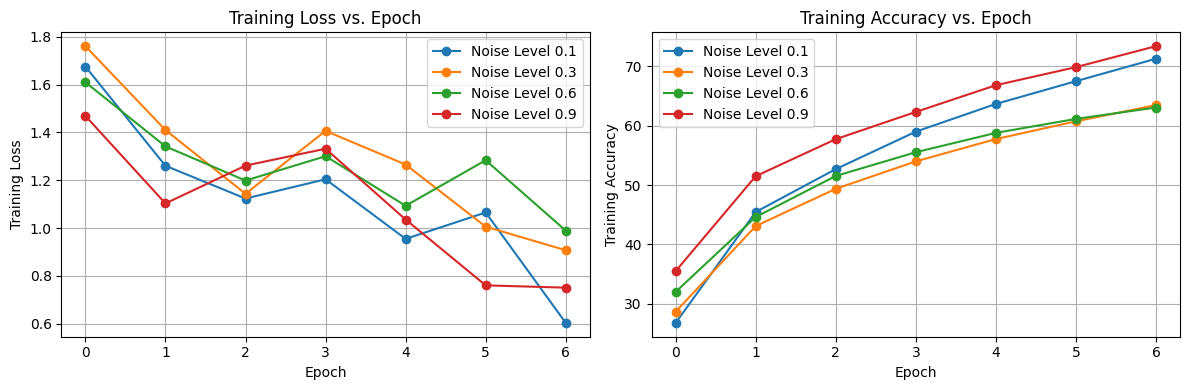

In [19]:
# plot training loss & accuracy for each noise level
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for epsilon, losses in train_losses.items():
    plt.plot(losses, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for epsilon, accuracies in train_accuracies.items():
    plt.plot(accuracies, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
test_accuracies = []
testing_times = []

# testing
for key, model_state_info in model_dict.items():
    model = BaselineModel()
    model_state = model.state_dict()
    model_state.update({k: v for k, v in model_state_info['state_dict'].items() if k in model_state})

    # load the updated state_dict
    model.load_state_dict(model_state)

    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    # initialize variables to measure testing time
    start_time_test = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure testing time
    total_test_time = time.time() - start_time_test
    testing_times.append(total_test_time)
    print(f'Total Testing Time for {key}: {total_test_time:.2f} seconds')

    # calculate test accuracy
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for {key}: {accuracy}')

# print the total time for the entire testing process
total_testing_process_time = sum(testing_times)
print(f'Total Testing Process Time: {total_testing_process_time:.2f} seconds')

Total Testing Time for noise_level_10_asy: 3.49 seconds
Test Accuracy for noise_level_10_asy: 0.6621
Total Testing Time for noise_level_30_asy: 2.72 seconds
Test Accuracy for noise_level_30_asy: 0.6151
Total Testing Time for noise_level_60_asy: 3.62 seconds
Test Accuracy for noise_level_60_asy: 0.4827
Total Testing Time for noise_level_90_asy: 2.62 seconds
Test Accuracy for noise_level_90_asy: 0.4308
Total Testing Process Time: 12.44 seconds


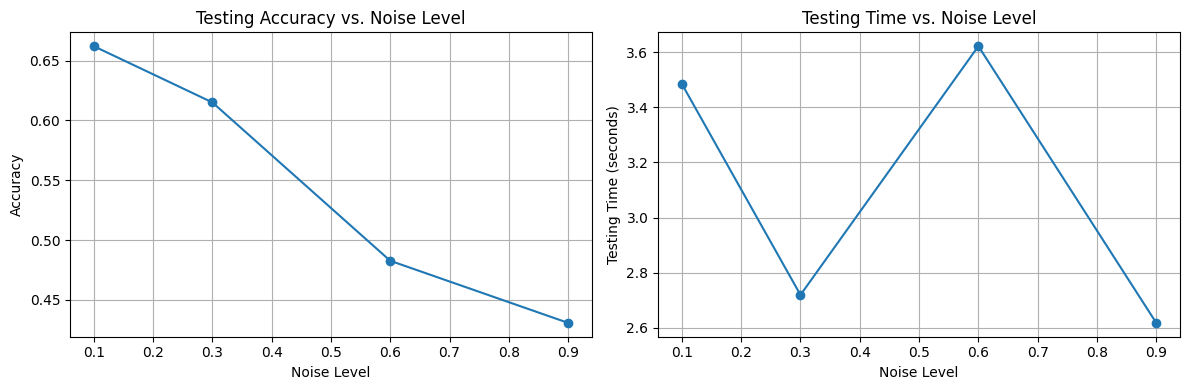

In [21]:
# plot testing accuracy and time
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, test_accuracies, marker='o')
plt.title('Testing Accuracy vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels,  testing_times, marker='o')
plt.title('Testing Time vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Testing Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Applying dynamic weights of samples to the BaselineModel

- use compute_sample_weights(), and integrate the weighted loss calculation into the training loop


---



*hyper parameter tuning*

1.   num of epoch
2.   threshold in compute_sample_weights() : Starting with a low threshold and gradually increasing it to observe how the model's performance changes.




In [27]:
# compute sample weights based on prediction confidence with threshold
def compute_sample_weights(outputs, labels, threshold=0.6):
    confidences, _ = torch.max(nn.functional.softmax(outputs, dim=1), dim=1)
    weights = torch.where(confidences < threshold, torch.tensor(1.0), 1.0 / confidences)
    return weights

## Symmetric

In [28]:
# create a dictionary with keys in the format 'noise_level_{100 * value}'
model_dict = {f'noise_level_{int(100 * level)}_sy': None for level in noise_levels}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize lists to store metrics
train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
training_times = []
validation_times = []

# training
for epsilon in noise_levels:

    model = BaselineModel()
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)  # Learning rate scheduler (cosine annealing)

    model.train()

    print(f"Symmetric Training with noise level: {epsilon}")

    # initialize variables to measure training time
    start_time_train = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:

            # add symmetric noise to labels
            labels = apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='symmetric')
            labels = torch.from_numpy(labels)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # compute sample weights
            weights = compute_sample_weights(outputs, labels)

            # apply weights to the loss
            weighted_loss = (loss * weights).mean()

            weighted_loss.backward()
            optimizer.step()

            # calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Training Time: {epoch_time:.2f}')

        # store training metrics
        train_losses[epsilon].append(loss.item())
        train_accuracies[epsilon].append(100 * total_correct / total_samples)

        # update learning rate
        scheduler.step()

    # store total training time
    total_train_time = time.time() - start_time_train
    training_times.append(total_train_time)
    print(f'Total Training Time for noise level {epsilon}: {total_train_time:.2f} seconds')

    # validation
    model.eval()

    # initialize variables to measure validation time
    start_time_val = time.time()

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure and print validation time
    total_val_time = time.time() - start_time_val
    validation_times.append(total_val_time)
    print(f'Total Validation Time for noise level {epsilon}: {total_val_time:.2f} seconds')

    # store validation metrics
    val_accuracy = correct / total
    average_val_loss = val_loss / len(val_loader)
    val_losses[epsilon].append(average_val_loss)
    val_accuracies[epsilon].append(val_accuracy)

    print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {val_accuracy}')

    # save model to dictionary
    model_dict[f'noise_level_{int(100 * epsilon)}_sy'] = {
        'state_dict': model.state_dict(),
        'validation_loss': average_val_loss,
        'validation_accuracy': val_accuracy
    }

# print the total time for the entire training process
total_training_process_time = sum(training_times) + sum(validation_times)
print(f'Total Training Process Time: {total_training_process_time:.2f} seconds')


Symmetric Training with noise level: 0.1
Epoch 1/7, Loss: 1.7986887693405151, Training Time: 14.42
Epoch 2/7, Loss: 1.4786105155944824, Training Time: 13.93
Epoch 3/7, Loss: 1.4066823720932007, Training Time: 13.77
Epoch 4/7, Loss: 1.4580711126327515, Training Time: 13.89
Epoch 5/7, Loss: 1.380562424659729, Training Time: 13.67
Epoch 6/7, Loss: 1.399876594543457, Training Time: 13.67
Epoch 7/7, Loss: 1.2910799980163574, Training Time: 13.65
Total Training Time for noise level 0.1: 97.02 seconds
Total Validation Time for noise level 0.1: 2.59 seconds
Validation Loss: 0.9877805560827255, Validation Accuracy: 0.6628
Symmetric Training with noise level: 0.3
Epoch 1/7, Loss: 2.0784785747528076, Training Time: 13.81
Epoch 2/7, Loss: 2.0576703548431396, Training Time: 13.74
Epoch 3/7, Loss: 2.018953323364258, Training Time: 14.05
Epoch 4/7, Loss: 1.7795652151107788, Training Time: 14.07
Epoch 5/7, Loss: 1.9947572946548462, Training Time: 13.81
Epoch 6/7, Loss: 1.8291962146759033, Training Tim

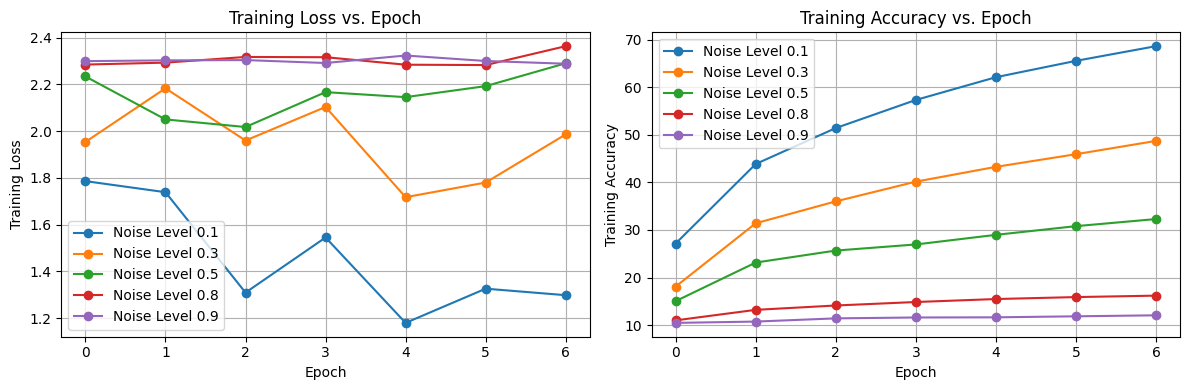

In [23]:
# plot training loss & accuracy for each noise level
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for epsilon, losses in train_losses.items():
    plt.plot(losses, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for epsilon, accuracies in train_accuracies.items():
    plt.plot(accuracies, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
test_accuracies = []
testing_times = []

# testing
for key, model_state_info in model_dict.items():
    model = BaselineModel()
    model_state = model.state_dict()
    model_state.update({k: v for k, v in model_state_info['state_dict'].items() if k in model_state})

    # load the updated state_dict
    model.load_state_dict(model_state)

    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    # initialize variables to measure testing time
    start_time_test = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure testing time
    total_test_time = time.time() - start_time_test
    testing_times.append(total_test_time)
    print(f'Total Testing Time for {key}: {total_test_time:.2f} seconds')

    # calculate test accuracy
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for {key}: {accuracy}')

# print the total time for the entire testing process
total_testing_process_time = sum(testing_times)
print(f'Total Testing Process Time: {total_testing_process_time:.2f} seconds')


Total Testing Time for noise_level_10_sy: 3.09 seconds
Test Accuracy for noise_level_10_sy: 0.6619
Total Testing Time for noise_level_30_sy: 2.47 seconds
Test Accuracy for noise_level_30_sy: 0.631
Total Testing Time for noise_level_60_sy: 2.57 seconds
Test Accuracy for noise_level_60_sy: 0.5142
Total Testing Time for noise_level_90_sy: 2.54 seconds
Test Accuracy for noise_level_90_sy: 0.3698
Total Testing Process Time: 10.68 seconds


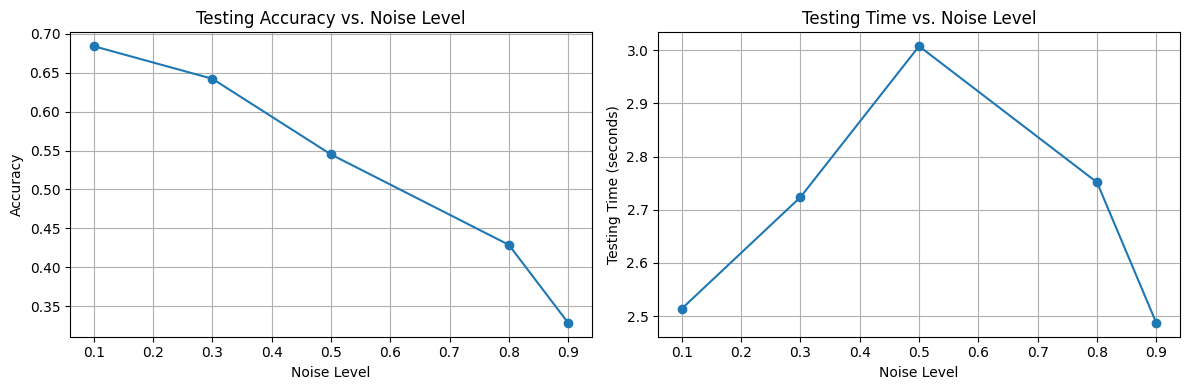

In [25]:
# plot testing accuracy and time
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, test_accuracies, marker='o')
plt.title('Testing Accuracy vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels, testing_times, marker='o')
plt.title('Testing Time vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Testing Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Asymmetric

In [26]:
# create a dictionary with keys in the format 'noise_level_{100 * value}'
model_dict = {f'noise_level_{int(100 * level)}_asy': None for level in noise_levels}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize lists to store metrics
train_losses = {epsilon: [] for epsilon in noise_levels}
train_accuracies = {epsilon: [] for epsilon in noise_levels}
val_losses = {epsilon: [] for epsilon in noise_levels}
val_accuracies = {epsilon: [] for epsilon in noise_levels}
training_times = []
validation_times = []

# training
for epsilon in noise_levels:

    model = BaselineModel()
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)  # Learning rate scheduler (cosine annealing)

    model.train()

    print(f"Asymmetric Training with noise level: {epsilon}")

    # initialize variables to measure training time
    start_time_train = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:

            # add asymmetric noise to labels
            labels = apply_label_noise(labels.numpy(), epsilon=epsilon, noise_type='asymmetric')
            labels = torch.from_numpy(labels)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # compute sample weights
            weights = compute_sample_weights(outputs, labels)

            # apply weights to the loss
            weighted_loss = (loss * weights).mean()

            weighted_loss.backward()
            optimizer.step()

            # calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        # measure and print epoch training time
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Training Time: {epoch_time:.2f}')

        # store training metrics
        train_losses[epsilon].append(loss.item())
        train_accuracies[epsilon].append(100 * total_correct / total_samples)

        # Update learning rate
        scheduler.step()

    # store total training time
    total_train_time = time.time() - start_time_train
    training_times.append(total_train_time)
    print(f'Total Training Time for noise level {epsilon}: {total_train_time:.2f} seconds')

    # validation
    model.eval()

    # initialize variables to measure validation time
    start_time_val = time.time()

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure and print validation time
    total_val_time = time.time() - start_time_val
    validation_times.append(total_val_time)
    print(f'Total Validation Time for noise level {epsilon}: {total_val_time:.2f} seconds')

    # store validation metrics
    val_accuracy = correct / total
    average_val_loss = val_loss / len(val_loader)
    val_losses[epsilon].append(average_val_loss)
    val_accuracies[epsilon].append(val_accuracy)

    print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {val_accuracy}')

    # save model to dictionary
    model_dict[f'noise_level_{int(100 * epsilon)}_asy'] = {
        'state_dict': model.state_dict(),
        'validation_loss': average_val_loss,
        'validation_accuracy': val_accuracy
    }

# print the total time for the entire training process
total_training_process_time = sum(training_times) + sum(validation_times)
print(f'Total Training Process Time: {total_training_process_time:.2f} seconds')


Asymmetric Training with noise level: 0.1
Epoch 1/7, Loss: 1.6406488418579102, Training Time: 13.75
Epoch 2/7, Loss: 1.4868812561035156, Training Time: 13.91
Epoch 3/7, Loss: 0.9947275519371033, Training Time: 13.92
Epoch 4/7, Loss: 1.2446458339691162, Training Time: 13.75
Epoch 5/7, Loss: 0.5541236996650696, Training Time: 13.73
Epoch 6/7, Loss: 0.9391254186630249, Training Time: 13.99
Epoch 7/7, Loss: 0.8162002563476562, Training Time: 14.17
Total Training Time for noise level 0.1: 97.23 seconds
Total Validation Time for noise level 0.1: 2.72 seconds
Validation Loss: 0.9335327297449112, Validation Accuracy: 0.6988
Asymmetric Training with noise level: 0.3
Epoch 1/7, Loss: 1.6650274991989136, Training Time: 13.71
Epoch 2/7, Loss: 1.5480245351791382, Training Time: 13.97
Epoch 3/7, Loss: 1.3846559524536133, Training Time: 13.74
Epoch 4/7, Loss: 1.2337236404418945, Training Time: 15.70
Epoch 5/7, Loss: 1.356614351272583, Training Time: 13.71
Epoch 6/7, Loss: 0.8700761795043945, Training

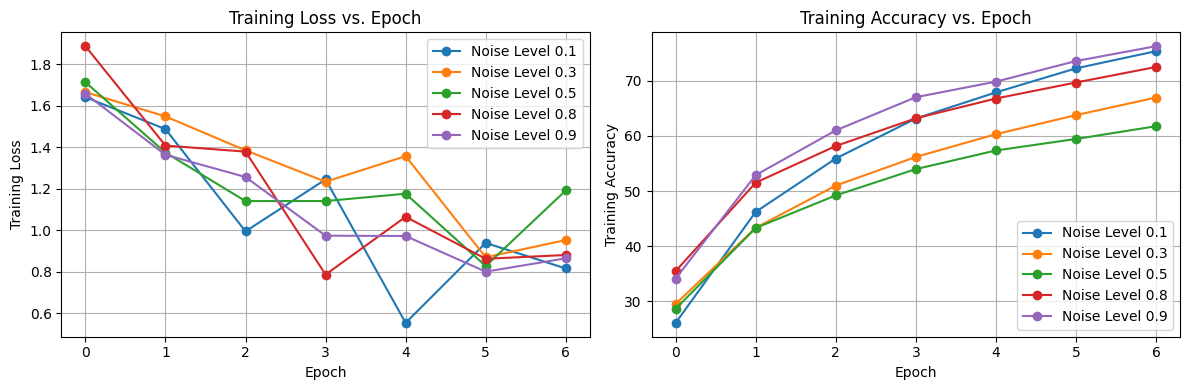

In [27]:
# plot training loss & accuracy for each noise level
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for epsilon, losses in train_losses.items():
    plt.plot(losses, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for epsilon, accuracies in train_accuracies.items():
    plt.plot(accuracies, label=f'Noise Level {epsilon}', marker='o')

plt.title('Training Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
test_accuracies = []
testing_times = []

# testing
for key, model_state_info in model_dict.items():
    model = BaselineModel()
    model_state = model.state_dict()
    model_state.update({k: v for k, v in model_state_info['state_dict'].items() if k in model_state})

    # load the updated state_dict
    model.load_state_dict(model_state)

    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    # initialize variables to measure testing time
    start_time_test = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # measure testing time
    total_test_time = time.time() - start_time_test
    testing_times.append(total_test_time)
    print(f'Total Testing Time for {key}: {total_test_time:.2f} seconds')

    # calculate test accuracy
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for {key}: {accuracy}')

# print the total time for the entire testing process
total_testing_process_time = sum(testing_times)
print(f'Total Testing Process Time: {total_testing_process_time:.2f} seconds')


Total Testing Time for noise_level_10_asy: 3.34 seconds
Test Accuracy for noise_level_10_asy: 0.698
Total Testing Time for noise_level_30_asy: 2.46 seconds
Test Accuracy for noise_level_30_asy: 0.6396
Total Testing Time for noise_level_50_asy: 2.46 seconds
Test Accuracy for noise_level_50_asy: 0.5315
Total Testing Time for noise_level_80_asy: 2.51 seconds
Test Accuracy for noise_level_80_asy: 0.4469
Total Testing Time for noise_level_90_asy: 2.68 seconds
Test Accuracy for noise_level_90_asy: 0.4426
Total Testing Process Time: 13.45 seconds


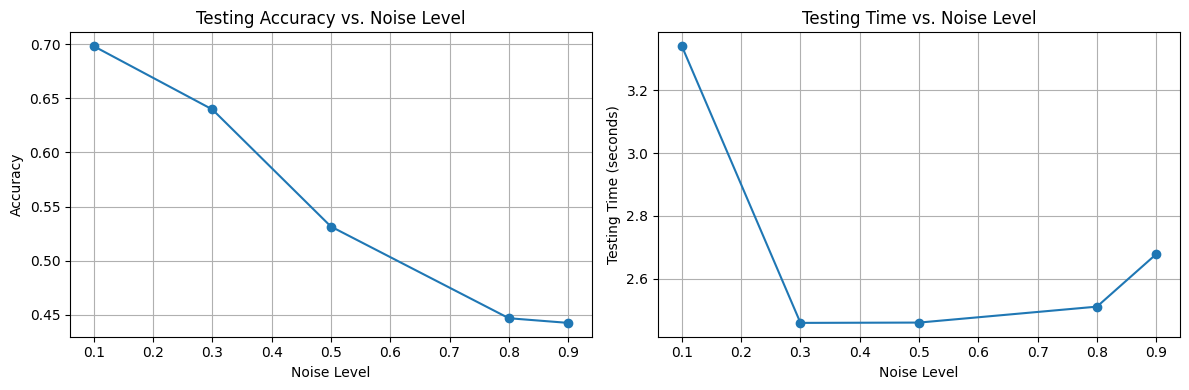

In [29]:
# plot testing accuracy and time
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, test_accuracies, marker='o')
plt.title('Testing Accuracy vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels, testing_times, marker='o')
plt.title('Testing Time vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Testing Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()